In [1]:
import matplotlib.pyplot as plt
import pathlib, os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from urllib.request import urlopen
from skimage import io
import seaborn as sns
import requests
import urllib
import cv2
from io import BytesIO
from PIL import Image
from os import path

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
categories = ['Baby','Home Improvement','Pet Supplies','Kitchen & Dining',
              'Automotive','Computers','Cell Phones & Accessories',
              'Health & Personal Care','Beauty','Grocery & Gourmet Food',
              'Patio, Lawn & Garden','Arts, Crafts & Sewing',
              'Musical Instruments','Home &amp; Kitchen','Clothing',
              'Jewelry','Electronics','Camera & Photo','Watches','Shoes']

In [3]:
image_array = np.load('../input/data-amazon-product-image-250-new/image_array.npy')
label_array = np.load('../input/data-amazon-product-image-250-new/label_array.npy')

In [4]:
# for i in label_array:
#     (categories[i])

In [5]:
train_images, test_images, train_labels, test_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels=train_test_split(train_images, train_labels,
                                                                      test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3592
Number of validation samples : 899
Number of       test samples : 500


In [6]:
# 1. Create a base model with tf.keras.applications

base_model = tf.keras.applications.InceptionV3(include_top= False)

# 2. Freeze the base model
base_model.trainable = False

#3. Create inputs into models
inputs = tf.keras.layers.Input(shape =(224,224,3), name = "input-layer")

#4. Rescaling
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

#5. Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

#7. Create the output activation layer
outputs = tf.keras.layers.Dense(20, activation = "softmax", name = "output-layer")(x)

# 8. Combine the inputs with outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics = ["accuracy"])

model_0.summary()

2022-10-07 06:56:21.910745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 06:56:22.017274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 06:56:22.018121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 06:56:22.020297: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 5, 5, 2048)
Shape after GlobalAveragePooling2D: (None, 2048)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input-layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling_layer (None, 2048)              0         
_________________________________________________________________
output-layer (Dense)         (None, 20)                40980     
Total params: 21,843,764
Trainable params: 40,980
Non-trainable params: 21,802,784
_________________________________________________________________


In [7]:
# Freeze top layers of Base Model
# To begin fine-tuning lets start by setting the last 10 layers as trainable

base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile (we have to compile model every time there is a change)
model_0.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), # when fine-tuning you typically want to lower lr by 10x
                metrics = ["accuracy"] )

In [8]:
EPOCHS = 20
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.3, min_lr=0.000001)
history = model_0.fit(train_images, train_labels, batch_size = 64 , epochs = EPOCHS, 
                    validation_data = (val_images,  val_labels) ,callbacks = [learning_rate_reduction])

2022-10-07 06:56:29.334828: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-07 06:56:31.855483: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-07 06:56:33.739070: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-10-07 06:56:38.320592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - ETA: 0s - loss: 2.3386 - accuracy: 0.3357

2022-10-07 06:56:49.982994: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.
2022-10-07 06:56:50.635952: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.


57/57 [==============================] - 20s 168ms/step - loss: 2.3386 - accuracy: 0.3357 - val_loss: 1.9683 - val_accuracy: 0.4427
Epoch 2/20
57/57 [==============================] - 6s 108ms/step - loss: 1.6593 - accuracy: 0.5053 - val_loss: 1.8506 - val_accuracy: 0.4650
Epoch 3/20
57/57 [==============================] - 6s 107ms/step - loss: 1.4552 - accuracy: 0.5635 - val_loss: 1.8360 - val_accuracy: 0.4572
Epoch 4/20
57/57 [==============================] - 6s 106ms/step - loss: 1.3288 - accuracy: 0.5910 - val_loss: 1.8051 - val_accuracy: 0.4872
Epoch 5/20
57/57 [==============================] - 6s 109ms/step - loss: 1.2103 - accuracy: 0.6281 - val_loss: 1.7726 - val_accuracy: 0.4939
Epoch 6/20
57/57 [==============================] - 6s 110ms/step - loss: 1.1042 - accuracy: 0.6623 - val_loss: 1.8061 - val_accuracy: 0.4828
Epoch 7/20
57/57 [==============================] - 6s 110ms/step - loss: 1.0234 - accuracy: 0.6876 - val_loss: 1.8259 - val_accuracy: 0.4750

Epoch 00007: Re

In [9]:
print("Loss of the model is - " , model_0.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , model_0.evaluate(test_images, test_labels)[1]*100 , "%")

2022-10-07 06:58:59.529761: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 301056000 exceeds 10% of free system memory.


16/16 [==============================] - 1s 68ms/step - loss: 1.8629 - accuracy: 0.4700
Loss of the model is -  1.8628908395767212
16/16 [==============================] - 1s 48ms/step - loss: 1.8629 - accuracy: 0.4700
Accuracy of the model is -  46.99999988079071 %


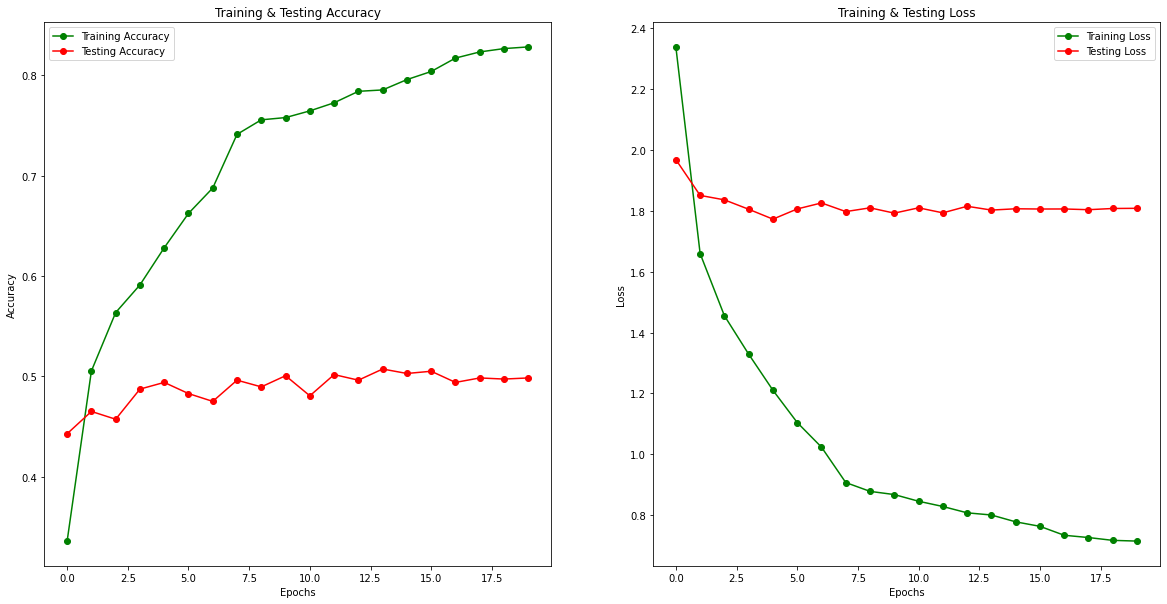

In [10]:
epochs = [i for i in range(EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [11]:
predictions = np.argmax(model_0.predict(test_images), axis=1) # this will pick the value in an array having the maximum score
predictions[:10]

array([10, 18,  7,  6,  0,  8,  8, 19, 16, 14])

In [12]:
print(classification_report(test_labels.astype(str), predictions.astype(str), target_names = categories))

                           precision    recall  f1-score   support

                     Baby       0.58      0.62      0.60        34
         Home Improvement       0.28      0.25      0.26        28
             Pet Supplies       0.40      0.42      0.41        24
         Kitchen & Dining       0.25      0.25      0.25        20
               Automotive       0.38      0.43      0.41        23
                Computers       0.20      0.19      0.19        16
Cell Phones & Accessories       0.59      0.76      0.67        21
   Health & Personal Care       0.82      0.72      0.77        32
                   Beauty       0.50      0.57      0.53        21
   Grocery & Gourmet Food       0.62      0.67      0.65        15
     Patio, Lawn & Garden       0.96      0.90      0.93        29
    Arts, Crafts & Sewing       0.85      0.85      0.85        20
      Musical Instruments       0.21      0.12      0.15        34
       Home &amp; Kitchen       0.25      0.35      0.29     